In [1]:
import os
import sys
sys.path.append('utils')
from dataset.spot import DailyDataset, get_loader, TOTAL_STD, TOTAL_MEAN, SPOT
from tool import to_gpu
import torch
import torch.nn as nn
from tqdm import trange, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math

import types
from decompose_model import TDec_RNN as DModel

%matplotlib inline

In [2]:
dataset1 = DailyDataset(N=2000, W=21)
loader1 = get_loader(dataset1, batch_size=64, shuffle=True, num_workers=2)

testX1, testY1 = dataset1.get_io('2011-06-30', '2016-06-30')

with torch.no_grad():
    test_period_input1= to_gpu(testY1)
    
PATH1 = './runs/decompose'
run1 = 'T_gru_h_24_soft_1e-2_3e-6_1e-2'
model1 = to_gpu(DModel(input_dim=24, output_dim=24, hidden_size=24, cell='gru', hard_gate=0))
snap1 = 'snapshots35'
model1.load_state_dict(torch.load(os.path.join(PATH1, run1, snap1+'.pth')))
test_period_output1 = model1.forecast(test_period_input1)
cache = test_period_output1[2][-7:]

Data build range: [window(2010-06-20 00:00:00) - 2010-07-11 00:00:00, 2015-12-31 00:00:00]


In [3]:
# from forecast_model import RNN as Model
# from forecast_model import LSTM as Model
from forecast_model import GRU as Model

In [4]:
def mae(pred, y_true, mode='default'):
    if mode == 'max':
        out = np.abs(pred.reshape(-1, 24).max(axis=-1) - y_true.reshape(-1, 24).max(axis=-1)).mean()
    elif mode == 'min':
        out = np.abs(pred.reshape(-1, 24).min(axis=-1) - y_true.reshape(-1, 24).min(axis=-1)).mean()
    else:
        out = np.abs(pred - y_true).mean()
    return out

def rmse(pred, y_true):
    out = np.power((pred - y_true), 2).mean()
    return math.sqrt(out)

def mape(pred, y_true, threshold=1e-2):
    pred.reshape(y_true.shape)
    f = lambda o,c: (math.fabs((o-c) / float(o)))*1.0 if math.fabs(o) > threshold else np.nan
    f = np.vectorize(f)
    error = f(y_true, pred)    
    errorCnts = error.shape[0]-np.sum(np.isnan(error),axis=0)
    error = np.nan_to_num(error)
    return np.sum(error, axis=0) / errorCnts

In [5]:
dataset = DailyDataset(N=1600, W=14, seasonal=1)
loader = get_loader(dataset, batch_size=64, shuffle=True, num_workers=2)

Data build range: [window(2011-08-01 00:00:00) - 2011-08-15 00:00:00, 2015-12-31 00:00:00]


In [6]:
trainX, trainY = dataset.get_io('2012-01-01', '2015-12-31')
testX, testY = dataset.get_io('2012-01-01', '2016-06-30')
with torch.no_grad():
    test_period_input = to_gpu(testX)

In [7]:
PATH = './runs/forecast/'
################################## RNN
# run = 'rnn-s'
# model = to_gpu(Model(input_dim=24*2, hidden_size=64, output_dim=24))
# model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots19.pth')))

################################## LSTM
# run = 'lstm-s'
# model = to_gpu(Model(input_dim=24*2, hidden_size=64, output_dim=24))
# model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots19.pth')))

################################### GRU
run = 'gru-s'
model = to_gpu(Model(input_dim=24*2, hidden_size=64, output_dim=24))
model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots17.pth')))


In [8]:
output, hidden = model.forecast(test_period_input)
test_period_forecast = output.cpu().detach().numpy()*TOTAL_STD + TOTAL_MEAN

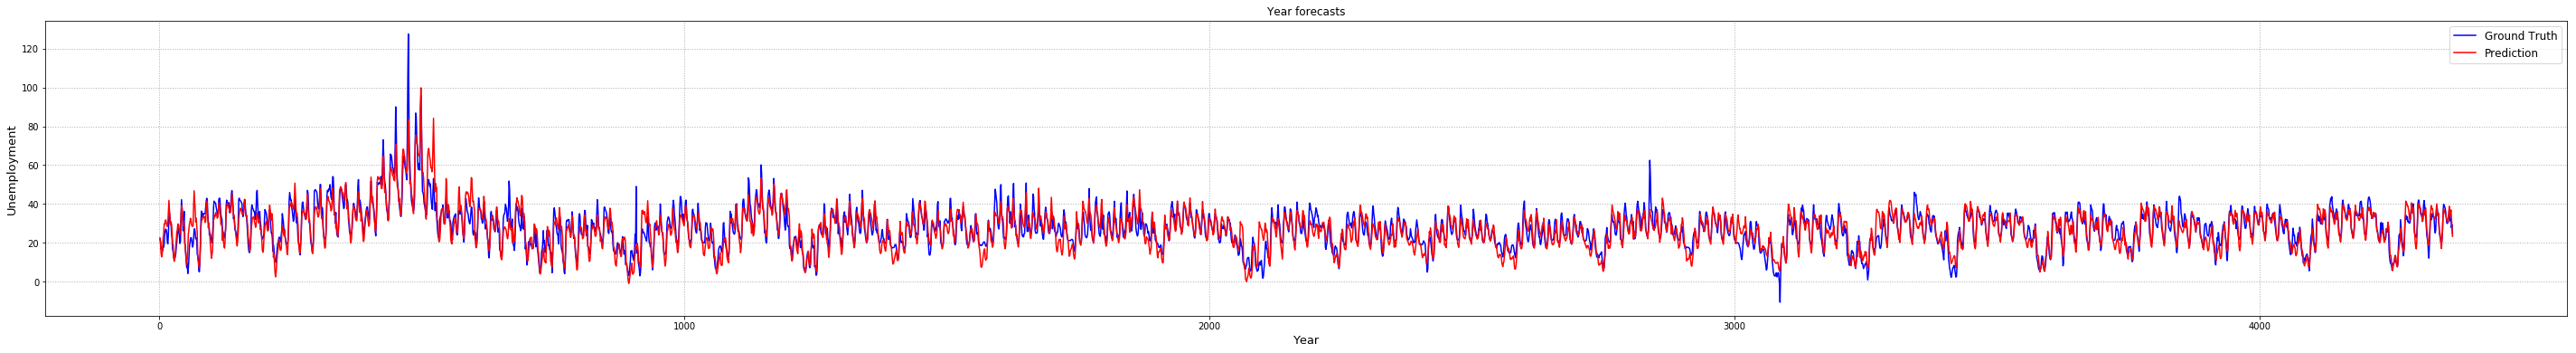

In [9]:
y_pred = test_period_forecast[-182:].reshape((182*24,))
y = torch.reshape(testY[-182:,:],(182*24,)).numpy() * TOTAL_STD + TOTAL_MEAN
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(50,6))
plt.plot(x, y[-182*24:], color='blue', label='Ground Truth')
plt.plot(x, y_pred[-182*24:], color='red', label='Prediction')

# plt.xticks(x)
# plt.xlim(0,23)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)

plt.show()

# rolling with cached seasonal series

In [10]:
outputs = []
H1 = []
output, h = model.forecast(torch.cat((to_gpu(testY[-1]).unsqueeze(0), cache[0].unsqueeze(0)), 1), hidden[-1])
outputs += [output]
H1 += [h[-1]]
i=1
for _ in trange(61):
    output, h = model.forecast(torch.cat((output, cache[i%7].unsqueeze(0)), 1), h[-1])
    outputs += [output]
    H1 += [h[-1]]
    i+=1
    
roll_output1 = torch.stack(outputs, 1).squeeze(2)[0]

100%|██████████| 61/61 [00:00<00:00, 1357.21it/s]


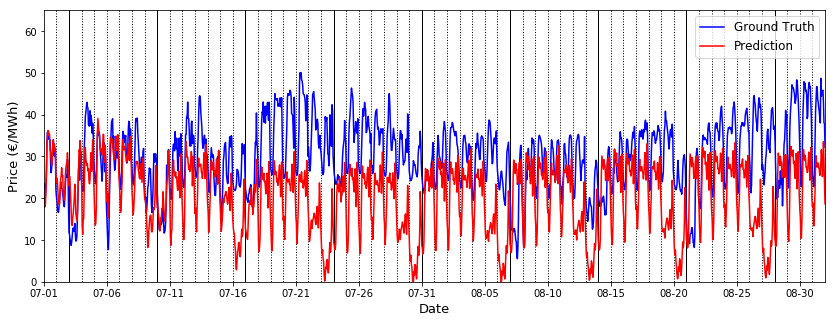

In [11]:
y_true = SPOT["2016-07-01":"2016-08-31"].values
y_pred = torch.reshape(roll_output1.cpu(),(62*24,)).detach().numpy() * TOTAL_STD + TOTAL_MEAN
x=np.linspace(1, 62*24, 62*24)
plt.figure(figsize=(14,5))
plt.plot(x, y_true, color='blue', label='Ground Truth')
plt.plot(x, y_pred, color='red', label='Prediction')
plt.legend(fontsize='large') # 显示图例

plt.xlim(0,62*24)
plt.ylim(0,65)
plt.vlines(np.array(range(1, 62, 1))*24, ymax=100, ymin=-10, linestyle=':', linewidth=1)
plt.vlines(np.array(range(2, 62, 7))*24, ymax=100, ymin=-10, linestyle='-', linewidth=1)
plt.xticks(np.array(range(0, 62, 5))*24, 
           ['07-01','07-06','07-11','07-16','07-21', '07-26', '07-31', '08-05','08-10','08-15','08-20','08-25','08-30'])

plt.xlabel('Date',fontsize=13)
plt.ylabel('Price (€/MWh)',fontsize=13)

# plt.savefig('./figures/roll_rnn_cache.jpg',bbox_inches='tight')

plt.show()

In [12]:
mae(y_pred, y_true), rmse(y_pred, y_true), mape(y_pred, y_true)

(10.658288598265699, 12.833458530303803, 0.37276718711274937)

In [13]:
mae(y_pred[:14*24], y_true[:14*24]), rmse(y_pred[:14*24], y_true[:14*24]), mape(y_pred[:14*24], y_true[:14*24])

(5.341019330024719, 6.656203955826868, 0.21563994668670783)

# rolling with seasonal decomposition

In [14]:
outputs = []
seasonal = []
trend = []
H2 = []
state = test_period_output1[-1]
s = model1.forecast(to_gpu(testY[-1]).unsqueeze(0), state)
output, h = model.forecast(torch.cat((to_gpu(testY[-1]).unsqueeze(0), s[2]), 1), hidden[-1])
outputs += [output]
seasonal += [s[2]]
trend += [s[3]]
H2 += [h[-1]]
for _ in trange(61):
    s = model1.forecast(output, s[-1])
    output, h = model.forecast(torch.cat((output, s[2]), 1), h[-1])
    outputs += [output]
    seasonal += [s[2]]
    trend += [s[3]]
    H2 += [h[-1]]

roll_output2 = torch.stack(outputs, 1).squeeze(2)[0]

100%|██████████| 61/61 [00:00<00:00, 431.37it/s]


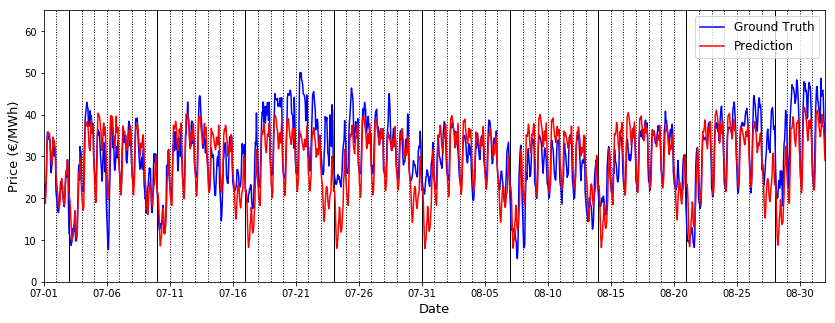

In [15]:
y_true = SPOT["2016-07-01":"2016-08-31"].values
y_pred = torch.reshape(roll_output2.cpu(),(62*24,)).detach().numpy() * TOTAL_STD + TOTAL_MEAN
x=np.linspace(1, 62*24, 62*24)
plt.figure(figsize=(14,5))
plt.plot(x, y_true, color='blue', label='Ground Truth')
plt.plot(x, y_pred, color='red', label='Prediction')
plt.legend(fontsize='large') # 显示图例

plt.xlim(0,62*24)
plt.ylim(0,65)
plt.vlines(np.array(range(1, 62, 1))*24, ymax=100, ymin=-10, linestyle=':', linewidth=1)
plt.vlines(np.array(range(2, 62, 7))*24, ymax=100, ymin=-10, linestyle='-', linewidth=1)
plt.xticks(np.array(range(0, 62, 5))*24, 
           ['07-01','07-06','07-11','07-16','07-21', '07-26', '07-31', '08-05','08-10','08-15','08-20','08-25','08-30'])

plt.xlabel('Date',fontsize=13)
plt.ylabel('Price (€/MWh)',fontsize=13)

# plt.savefig('./figures/roll_rnn_decom.jpg',bbox_inches='tight')

plt.show()

In [16]:
mae(y_pred, y_true), rmse(y_pred, y_true), mape(y_pred, y_true)

(4.322560493817893, 5.53978196139841, 0.16057441056964553)

In [17]:
mae(y_pred[:14*24], y_true[:14*24]), rmse(y_pred[:14*24], y_true[:14*24]), mape(y_pred[:14*24], y_true[:14*24])

(3.111587489900135, 4.019433502379122, 0.13647569895225564)

In [18]:
seasonal = torch.stack(seasonal, 1).squeeze(2)[0]
trend = torch.stack(trend, 1).squeeze(2)[0]
seasonal = torch.reshape(seasonal.cpu(),(62*24,)).detach().numpy() * TOTAL_STD
trend = torch.reshape(trend.cpu(),(62*24,)).detach().numpy() * TOTAL_STD + TOTAL_MEAN
residual = y_pred-seasonal-trend

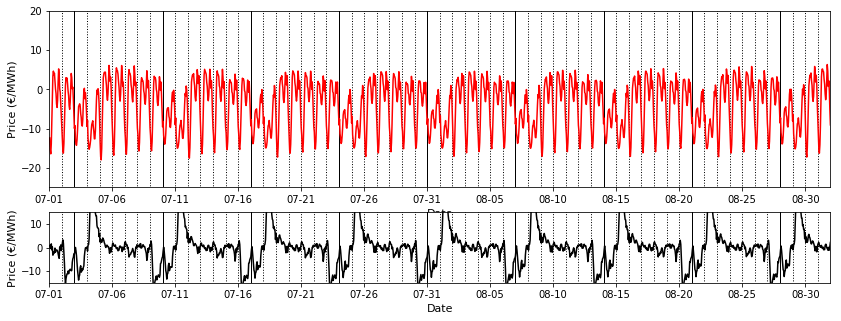

In [19]:
x=np.linspace(1, 62*24, 62*24)
fig = plt.figure(figsize=(14,5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 2]) 
ax1 = plt.subplot(gs[0])
ax1.plot(x, seasonal, color='red')
# ax1.legend(fontsize=11) # 显示图例

ax1.set_xlim(0,62*24)
ax1.set_ylim(-25,20)
ax1.set_xlabel('Date',fontsize=11)
ax1.set_ylabel('Price (€/MWh)',fontsize=11)

ax1.vlines(np.array(range(1, 62, 1))*24, ymax=100, ymin=-30, linestyle=':', linewidth=1)
ax1.vlines(np.array(range(2, 62, 7))*24, ymax=100, ymin=-30, linestyle='-', linewidth=1)
ax1.set_xticks(np.array(range(0, 62, 5))*24) 
ax1.set_xticklabels(['07-01','07-06','07-11','07-16','07-21','07-26', '07-31','08-05','08-10','08-15','08-20','08-25','08-30'])

ax2 = plt.subplot(gs[1]) 
ax2.plot(x, residual, color='black')
# ax2.legend(fontsize=11) # 显示图例

ax2.set_xlim(0,62*24)
ax2.set_ylim(-15,15)
ax2.set_xlabel('Date',fontsize=11)
ax2.set_ylabel('Price (€/MWh)',fontsize=11)

ax2.vlines(np.array(range(1, 62, 1))*24, ymax=100, ymin=-30, linestyle=':', linewidth=1)
ax2.vlines(np.array(range(2, 62, 7))*24, ymax=100, ymin=-30, linestyle='-', linewidth=1)
ax2.set_xticks(np.array(range(0, 62, 5))*24) 
ax2.set_xticklabels(['07-01','07-06','07-11','07-16','07-21','07-26', '07-31','08-05','08-10','08-15','08-20','08-25','08-30'])

# plt.tight_layout() 

# plt.savefig('./figures/roll_rnn_seasonal.jpg',bbox_inches='tight')
plt.show()

In [9]:
h_s = torch.stack(hidden, 1).squeeze(2)[0].mean(dim=1).cpu().data.numpy()
var_s = torch.stack(hidden, 1).squeeze(2)[0].std(dim=1).cpu().data.numpy()

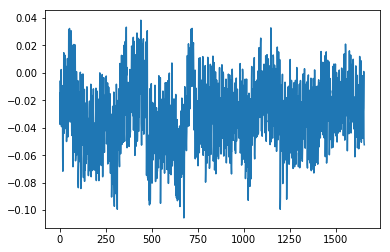

In [10]:
plt.plot(h_s)

In [11]:
# np.savetxt('./h_s.csv', h_s, delimiter = ',') 

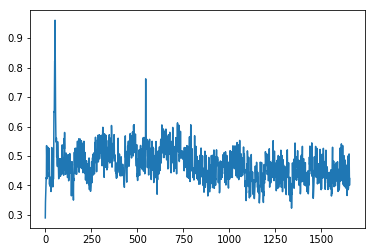

In [12]:
plt.plot(var_s)

In [13]:
# np.savetxt('./var_s.csv', var_s, delimiter = ',') 